# Tutorial 

## Aim

Scripts to compute and analyse the R-factor of the RUSLE-equation. The
R-factor is a measure for the total erosivity of a number of rainfall events
within a defined timeframe (year, month, number of days). The factor is
computed by calculating the yearly sum of -for every rainfall event- the sum
of the depth of rainfall (mm) and the kinetic energy, and taking the mean
over all years. For the formula's, we refer to the [CN-WS Pascal model documentation](https://docs.fluves.net/cnws-pascal/watem-sedem.html#rusle-factors)

## Imports
Main imports

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from pathlib import Path
import sys;
import os

Package imports

In [5]:
from rfactor.process import (ErosivityData, compute_rainfall_statistics, compute_rainfall_statistics)
from rfactor.rfactor import compute_rfactor

Working directory

In [6]:
cwd = Path().resolve()

**Set folders**  
The input files are defined by text files (extension: .txt) that hold non-zero rainfall timeseries. The data are split per station and per year with a specific datafile tag:  

KMI_6414_2004.txt  
KMI_6414_2005.txt  
...  
KMI_6434_2003.txt  
KMI_6434_2004.txt  
...  

In [7]:
fmap_rainfall=  Path(r"../../tests/data/test_rainfalldata")
fmap_erosivity = Path(r"../../tests/data/test_erosivitydata")
fmap_results = Path.cwd() / "results"

In [6]:
fmap_results

WindowsPath('C:/Users/SachaGobeyn/GitHub/rfactor/docs/notebooks/results')

**Rainfall files summary file**  
An overview of the present datafiles for the analysis is saved in a  `files.csv` file (example in *./tests/data*). This file can be used to remove specific files from the analysis (column `consider`):

   | source        | datafile      | consider  |
  | ------------- |:-------------:| ---------:|
  | KMI	          | KMI_6414_2004 | 0         |
  | KMI	          | KMI_6414_2005 | 1         |
  | KMI	          | KMI_6414_2006 | 1         |
  | ...           | ...           | ...       |


In [8]:
txt_files=  Path(r"data\belgium\files.csv")
txt_files.exists()

True

**Run Model**  
The current implemenation makes use of a Matlab engine, which requires Matlab to be installed. Future versions of this package will use Python. Results are 
written to the *./src/rfactor/results*-folder.

In [8]:
compute_rfactor(fmap_rainfall,fmap_results,"matlab")

**Set-up analysis**  
Create a erosivitydata object, build the data set with the *files.csv* file and load the rainfall and EI30 data.  
__NOTE__: 
1. Set the director back to the location of this file
2. If the <ins>**Matlab**</ins> is used, make sure **to first let the simulation end before executing the next line!!!!!**

In [9]:
os.chdir(cwd)
data = ErosivityData(fmap_rainfall,fmap_erosivity)
df_files = data.build_data_set(txt_files)
data.load_data(df_files)
df_files.to_csv("overview_files_stations.csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.36it/s]


**Rainfall statistics**  
Compute rainfall statistics

In [ ]:
compute_rainfall_statistics(data.load_rainfall(),pd.read_csv("data/belgium/stations.csv"))

## Ukkel  
Compute R-value for specific years for Ukkel (KMI_6447 and KMI_F3)

In [23]:
timeseries = [range(1898,2003,1),
              range(2003,2021,1),
              range(1898,2021,1),
              range(1996,2021,1),
              range(1991,2021,1),
              range(1990,2001,1),
              range(2000,2021,1)]
for i in timeseries:
    print(i)
    df_R=data.load_R(["KMI_6447","KMI_FS3"], i)
    print(np.mean(df_R["value"]))

range(1898, 2003)
958.1058095238095
range(2003, 2021)
1277.1105882352942
range(1898, 2021)
1002.5572950819671
range(1996, 2021)
1237.3845833333335
range(1991, 2021)
1239.4468965517242
range(1990, 2001)
1094.6436363636362
range(2000, 2021)
1272.7740000000001


In [24]:
len(data.stations)

57

**Make figure for Ukkel**

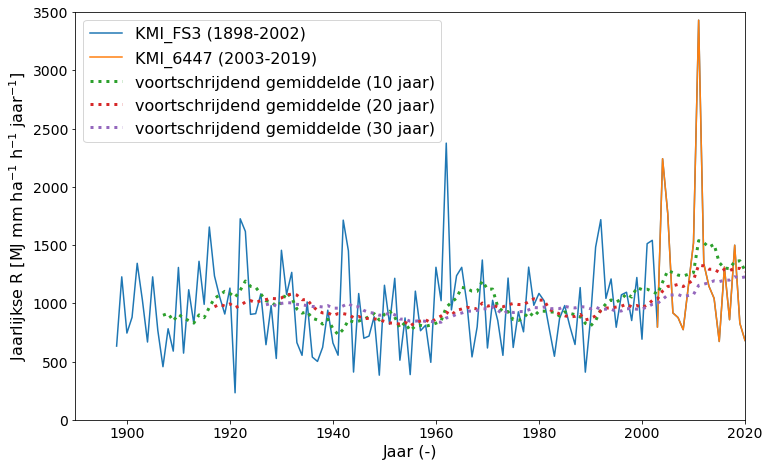

In [61]:
plt.figure(figsize=[12,7.5])
df_R=data.load_R(["KMI_6447","KMI_FS3"], years)
df_R = df_R[~np.isnan(df_R["value"])].sort_values("year")
plt.plot(df_R["year"],df_R["value"],label="KMI_FS3 (1898-2002)")
years = np.arange(2003,2021,1)
df_R=data.load_R(["KMI_6447","KMI_FS3"], years)
df_R = df_R[~np.isnan(df_R["value"])].sort_values("year")
plt.plot(df_R["year"],df_R["value"],label="KMI_6447 (2003-2019)")

# rolling mean
scales  = [10,20,30]
years = np.arange(1898,2021,1)
df_R=data.load_R(["KMI_6447","KMI_FS3"], years)
df_R = df_R[~np.isnan(df_R["value"])].sort_values("year")
for scale in scales:
    y = df_R["value"].rolling(scale).mean()
    x = y.index+1898
    plt.plot(x,y,ls=':',lw=3,label=f'voortschrijdend gemiddelde ({scale} jaar)')
plt.ylim([0,3500])
plt.xlim([1890,2020])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel(r'Jaar (-)',fontsize=16)
plt.ylabel(r'Jaarlijkse R [MJ mm ha$^{-1}$ h$^{-1}$ jaar$^{-1}$]',fontsize=16)
plt.legend(prop={'size':16})

In [57]:
len(x)

112

## Flanders and Belgium
**All stations expect Ukkel**

In [ ]:
stations_belgium_excl_ukkel = [station for station in data.stations if station not in ["KMI_6447","KMI_FS3"]]
df_R=data.load_R(stations_belgium_excl_ukkel)
print(np.mean(df_R["value"]))
len(stations_belgium_excl_ukkel)

**All stations except Ukkel and Wallonia**

In [ ]:
stations_flanders_excl_ukkel = [station for station in data.stations if station not in  ["KMI_6447","KMI_FS3","KMI_6455","KMI_6459","KMI_6472","KMI_6494","KMI_6484"]]
df_R=data.load_R(stations_flanders_excl_ukkel, i)
print(np.mean(df_R["value"]))
len(stations_flanders_excl_ukkel)

**Plot the distribution of all R-values for Belgium, excluding the data from Ukkel**

1171.538046511628


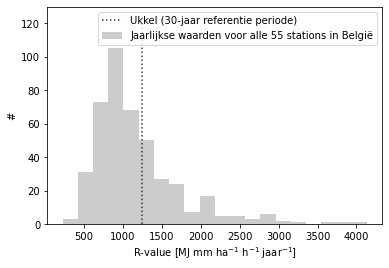

In [22]:
stations_flanders_excl_ukkel = [station for station in data.stations if station not in  ["KMI_6447","KMI_FS3"]]
df_R=data.load_R(stations_flanders_excl_ukkel, range(1991, 2021))
print(np.mean(df_R["value"]))
len(stations_flanders_excl_ukkel)
plt.hist(df_R["value"],20,color=[0.8]*3,label=r"Jaarlijkse waarden voor alle 55 stations in België")
plt.plot([1239,1239],[0,120],color=[0.2]*3,ls=":",label="Ukkel (30-jaar referentie periode)")
plt.ylabel(r"#")
plt.xlabel(r"R-value [MJ mm ha$^{-1}$ h$^{-1}$ jaar$^{-1}$]")
plt.ylim([0,130])
plt.legend()

**All stations of the VMM (Flanders)**

In [ ]:
stations_flanders_excl_ukkel = [station for station in data.stations if "KMI" not in station]
df_R=data.load_R(stations_flanders_excl_ukkel, i)
print(np.mean(df_R["value"]))
len(stations_flanders_excl_ukkel)

**Compute values per year over all stations**

In [ ]:
df_R.groupby("station").aggregate({"value":[np.mean,np.std],"year":lambda x:len(x)}).sort_values(('year', '<lambda>'),ascending=False).reset_index()

## Monthly analysis
Get the EI30-values for 2018 based on two Ukkel station ("KMI_6447","KMI_FS3")  

In [28]:
df_EI30 = data.load_EI30(["KMI_6447","KMI_FS3"],range(1898,2021,1))

**Data formatting**

In [29]:
df_EI30["m"] = df_EI30.index.strftime("%m%d")
df_EI30.loc[df_EI30["m"]=="0229","m"] = "0228"
df_m = df_EI30.groupby("m").aggregate({"value":[np.mean,np.std,lambda x:np.percentile(x,25),lambda x:np.percentile(x,75)]})
df_m["mean"] = df_m[("value","mean")];df_m["std"] = df_m[("value","std")];df_m["p25"] = df_m[('value', '<lambda_0>')];df_m["p75"] = df_m[('value', '<lambda_1>')];df_m["p25_e"] = df_m["mean"]-df_m['p25'];df_m["p75_e"] = df_m['p75']-df_m["mean"]

**Plot**

Text(0, 0.5, 'R-waarde [MJ mm ha$^{-1}$ h$^{-1}$ maand$^{-1}$]')

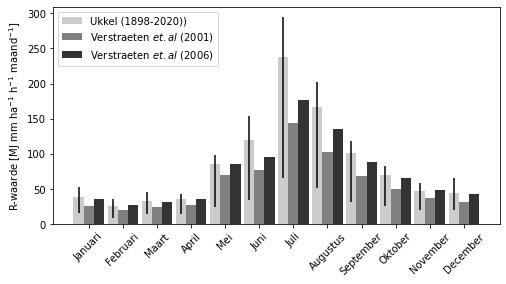

In [34]:
fig = plt.figure(figsize=(8,4))
x = np.arange(len(df_m))
y_gv = [26,20,24,27,70,77,144,102,68,50,37,32]
y_gv2 = [35,27,32,36,86,96,177,135,89,66,48,43]
plt.bar(x-0.3,df_m["mean"],yerr=df_m[["p25_e","p75_e"]].T.values,color=[0.80]*3,width=0.3,label="Ukkel (1898-2020))")
plt.bar(x,y_gv,width=0.3,color=[0.5]*3,label="Verstraeten $\it{et. al}$ (2001)")
plt.bar(x+0.3,y_gv2,width=0.3,color=[0.2]*3,label="Verstraeten $\it{et. al}$ (2006)")
plt.ylabel("R-value")
ax = fig.axes
plt.xticks(x,["Januari","Februari","Maart","April","Mei","Juni","Juli","Augustus","September","Oktober","November","December"],rotation=45)
plt.legend(loc=2,facecolor ="white")
plt.ylabel(r"R-waarde [MJ mm ha$^{-1}$ h$^{-1}$ maand$^{-1}$]")

## Appendix B: monthly analysis (detail)
**Evolution monthly R-value**
Generate plot to analyse evolution of montly R over the years

TypeError: subplot_montlhy_R() missing 2 required positional arguments: 'ind1' and 'ind2'

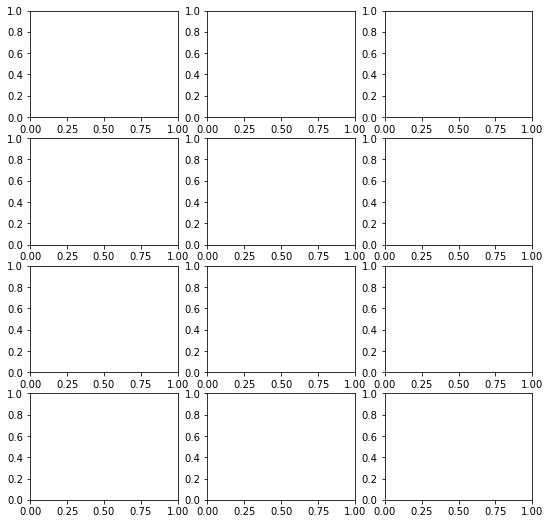

In [44]:
def subplot_montlhy_R(df,ax,ind1,ind2):

    if (ind1==0) & (ind2==2):
        ax.plot(df["year"],df["value"],color=[0.1]*3,alpha=0.5,label="EI30")
    else:
        ax.plot(df["year"],df["value"],color=[0.1]*3,alpha=0.5)
    ax.fill_between([1998,2021], 0,500,facecolor='grey', alpha=0.3)    
    # rolling mean
    scales  = [10,20,30]
    for scale in scales:
        y = df["value"].reset_index().rolling(scale).mean()
        if scale==10:
            y_max=np.nanmax(y.values)*1.1
        x = y.index+1898
        ax.plot(x,y,lw=2,label=f'voortschrijdend gemiddelde ({scale} jaar)')
    if ind1!=3:
        ax.set_xticks([])
    else:
        if ind2==1:
            ax.set_xlabel(r'Jaar (-)',fontsize=16)
    ax.set_ylim([0,500])
    ax.set_title(name)
    axtick_params(axis='y', which='major', labelsize=12,rotation=90)
    ax.tick_params(axis='x', which='major', labelsize=12)
    if ind2!=0:
        ax.set_yticklabels([])
    else:
        if ind1==2:
            ax.set_ylabel('\t\t\t Maandelijkse R [MJ mm ha$^{-1}$ h$^{-1}$ maand$^{-1}$]',fontsize=16)
    if (ind1==0) & (ind2==2):
        ax.legend(ncol=2)
        
fig,ax = plt.subplots(4,3,figsize=[9,9])
months = ["Januari","Februari","Maart","April","Mei","Juni","Juli","Augustus","September","Oktober","November","December"]
df_EI30["month"] = df_EI30.index.month
df_EI30["year"] = df_EI30.index.year

for month,name in enumerate(months):
    ind1=int(np.floor((month)/3))
    ind2=np.mod(month,3)
    df_EI30m = df_EI30.loc[df_EI30["month"]==month+1]
    df_EI30m = df_EI30m[~np.isnan(df_EI30m["value"])].sort_values("year")
    subplot_montlhy_R(df_EI30m,ax[ind1,ind2],ind1,ind2)



**Number of outliers in rainfall**

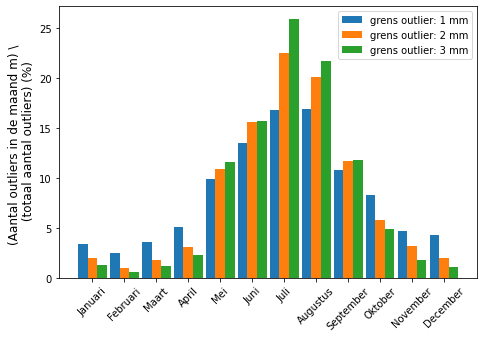

In [27]:
df_N=data.load_rainfall(["KMI_6447","KMI_FS3"], range(1898,2021,1))
labels = ["grens outlier: 1 mm","grens outlier: 2 mm","grens outlier: 3 mm"]

fig,ax = plt.subplots(figsize=[7.5,5])
for i in [1,2,3]:
    df_N_outliers = df_N[df_N["value"]>i].copy()
    df_N_outliers.loc[:,"month"] = df_N_outliers.index.month
    df_outliers = df_N_outliers.groupby("month").aggregate({"value":lambda x:len(x)})
    df_outliers.loc[:,"percentage"] = df_outliers["value"]/np.sum(df_outliers["value"])*100
    plt.bar(df_outliers.index+0.3*(i-2),df_outliers["percentage"],width=0.3,label=labels[i-1])

plt.xticks(range(1,13,1),["Januari","Februari","Maart","April","Mei","Juni","Juli","Augustus","September","Oktober","November","December"],rotation=45)
plt.ylabel("(Aantal outliers in de maand m) \ \n (totaal aantal outliers) (%)",fontsize=12)
plt.legend()